# ***Desafio 1***

O Objetivo deste desafio é buscar insights sobre os dados contidos em 'ofertas_relampago.csv'

## *EDA*

In [1]:
import IPython
from IPython.display import clear_output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install matplotlib
!pip install seaborn
clear_output()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [18, 8]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Aqui vamos ler os dados

In [3]:
nome_arquivo = 'ofertas_relampago.csv'
def ler_arquivo(nome,idf=True):
    df = pd.read_csv(nome, infer_datetime_format=idf)
    print(df.info())
    print("Dataframe shape: ",df.shape)
    return df    

In [4]:
data = ler_arquivo(nome_arquivo)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

Temos uma base com 48.746 observações e 13 colunas

Há dados nulos na base, como vimos no info, veremos agora percentualmente quantos desses dados são nulos por coluna

In [5]:
data.isna().sum() *100 / len(data)

OFFER_START_DATE              0.000000
OFFER_START_DTTM              0.000000
OFFER_FINISH_DTTM             0.000000
OFFER_TYPE                    0.000000
INVOLVED_STOCK                0.000000
REMAINING_STOCK_AFTER_END     0.000000
SOLD_AMOUNT                  49.577401
SOLD_QUANTITY                49.577401
ORIGIN                       76.785788
SHIPPING_PAYMENT_TYPE         0.000000
DOM_DOMAIN_AGG1               0.000000
VERTICAL                      0.000000
DOMAIN_ID                     0.000000
dtype: float64

In [6]:
data['ORIGIN'].fillna('-',inplace=True)
data['SHIPPING_PAYMENT_TYPE'] = np.where(data['SHIPPING_PAYMENT_TYPE'].astype(str)=='none', '-', data['SHIPPING_PAYMENT_TYPE'])

In [7]:
data['ORIGIN'].unique()

array(['A', '-'], dtype=object)

Percebemos que a origem só assume 1 valor "A"

In [8]:
data['SHIPPING_PAYMENT_TYPE'].unique()

array(['-', 'free_shipping'], dtype=object)

Vamos prencher os valores nulos baseados nas informações presentes de vendas e estoque, vou criar também o preço unitário dividindo o total vendido pela quantidade vendida

In [9]:
data['SOLD_QUANTITY'] = np.where(~data['SOLD_QUANTITY'].isna(), data["INVOLVED_STOCK"] - data["REMAINING_STOCK_AFTER_END"], 0)

In [10]:
data['UNIT_PRICE'] = data['SOLD_AMOUNT']/data['SOLD_QUANTITY']

Vamos validar quando aconteceram as ofertas:

In [11]:
data['Year'] = pd.DatetimeIndex(data["OFFER_START_DATE"]).year
data['Month'] = pd.DatetimeIndex(data["OFFER_START_DATE"]).month
data['Day'] = pd.DatetimeIndex(data["OFFER_START_DATE"]).day

In [12]:
data['Year'].unique()

array([2021])

In [13]:
data['Month'].unique()

array([6, 7])

As ofertas estão alocadas nos meses de Junho e Julho de 2021

Vamos criar a coluna de duração da oferta e uma coluna de duração total e uma coluna com total de horas e minutos da promoção

In [14]:
data["Duration"] = pd.to_datetime(data["OFFER_FINISH_DTTM"]) - pd.to_datetime(data["OFFER_START_DTTM"])

In [15]:
data["Duration_Hours"] = data["Duration"].dt.components.hours

In [16]:
data["Duration_Minutes"] = (data["Duration"].dt.components.hours) * 60 + data["Duration"].dt.components.minutes

In [17]:
data['Start_Hour'] = pd.to_datetime(data['OFFER_START_DTTM']).dt.hour

In [18]:
data['Start_Hour'].unique()

array([16, 13,  7, 19, 18, 15, 11, 14, 17, 12, 20, 21, 22, 10,  0,  8,  9,
        1,  3,  6, 23,  5,  2,  4])

In [19]:
#Crio uma função que vai assignar o período do dia baseado no horário que a promoção começou
def transform_Period_Dia(row):
    if row >= 6 and row < 12:
        return 'Manhã'
    elif row >= 12 and row < 18:
        return 'Tarde'
    elif row >= 18:
        return 'Noite'
    elif row >= 0 and row < 6:
        return 'Madrugada'

data['Period_of_Day'] = data.apply(lambda row: transform_Period_Dia(row['Start_Hour']), axis = 1)

#Crio uma função para faixas de estoque Pequeno - até 10 unidades, Médio - até 100 unidades e Grande - mais que 100 unidades
def transform_Faixa_Estoque(row):
    if row >= 100:
        return 'Grande'
    elif row >= 10 and row < 100:
        return 'Médio'
    else:
        return 'Pequeno'

data['Tamanho_Estoque'] = data.apply(lambda row: transform_Faixa_Estoque(row['INVOLVED_STOCK']), axis = 1)


In [20]:
data["Duration_Hours"].unique()

array([ 7,  6,  2,  4,  8,  3,  0,  5,  1, 10, 11, 14, 15, 12,  9])

Vou criar uma coluna de percentual de estoque vendido, para analisar além dos valores de venda absolutos (quantidade de vendas) o valor relativo a % do estoque e uma flag para caso tenha esgotado o estoque (1 - esgotou, 0 - não esgotou)

In [21]:
data["Perc_of_sells"] = (data["SOLD_QUANTITY"]/data["INVOLVED_STOCK"])*100

In [22]:
data['Esgotou_Estoque'] = np.where(data['Perc_of_sells']>= 100, 1, 0)

## Com uma primeira visão dos dados vou levantar algumas hipósteses que quero testar nesta exploração:
 - A duração da oferta cria algum senso de urgencia e influencia a quantidade de vendas?
 - O estoque limitado também influencia?
 - Separar as ofertas por período do dia que aconteceram (manhã/tarde/noite/madrugada) e entender se há influencia na quantidade de vendas
 - Os produtos com frete grátis performam melhores?
 - O que é a Origem? Vou investigar qual a diferença entre produtos com origem A para os outros
 - Quais categorias performaram melhor (Vertical/Domain_ID/DOM_DOMAIN_AGG1)?
 
## Infomações adicionais interessantes que poderiam dar mais insights:
  - Qual foi o percentual de desconto anunciado, isso influenciaria o numero de vendas? 
  - Qual o tempo original anunciado para o término da promoção, se isso foi um fator que influenciou as vendas?

In [23]:
data.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,UNIT_PRICE,Year,Month,Day,Duration,Duration_Hours,Duration_Minutes,Start_Hour,Period_of_Day,Tamanho_Estoque,Perc_of_sells,Esgotou_Estoque
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6,A,-,PETS FOOD,CPG,MLM-BIRD_FOODS,0.786667,2021,6,22,0 days 07:02:43,7,422,16,Tarde,Pequeno,150.000000,1
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,0,-,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,NaN,2021,6,22,0 days 06:00:02,6,360,13,Tarde,Pequeno,0.000000,0
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3,-,-,COMPUTERS,CE,MLM-SPEAKERS,3.576667,2021,6,22,0 days 06:00:01,6,360,7,Manhã,Médio,20.000000,0
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2,-,-,COMPUTERS,CE,MLM-HEADPHONES,3.515000,2021,6,22,0 days 06:36:12,6,396,19,Noite,Médio,13.333333,0
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15,-,-,COMPUTERS,CE,MLM-HEADPHONES,2.643333,2021,6,22,0 days 02:48:12,2,168,13,Tarde,Médio,100.000000,1


# - A duração da oferta cria algum senso de urgencia e influencia a quantidade de vendas?

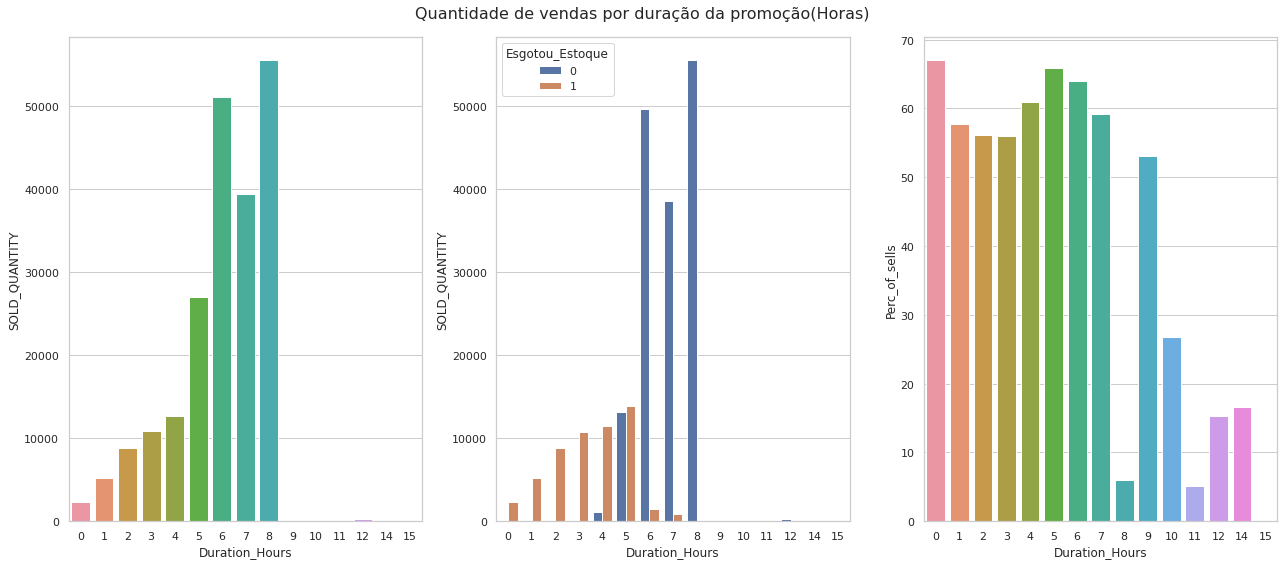

In [39]:
f = plt.figure()
f.suptitle('Quantidade de vendas por duração da promoção(Horas)', fontsize=16)

dataagg = data.groupby(['Duration_Hours'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(131)
ax1 = sns.barplot(x="Duration_Hours", y="SOLD_QUANTITY", data=dataagg,ci=None)

plt.tight_layout()

dataagg = data.groupby(['Duration_Hours','Esgotou_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(132)
ax1 = sns.barplot(x="Duration_Hours", y="SOLD_QUANTITY",hue='Esgotou_Estoque', data=dataagg,ci=None)
plt.tight_layout()

dataagg = data.groupby(['Duration_Hours','Esgotou_Estoque'], as_index=False)['Perc_of_sells'].mean()
ax2 = f.add_subplot(133)
ax2 = sns.barplot(x="Duration_Hours", y="Perc_of_sells", data=dataagg,ci=None)
plt.tight_layout()

plt.show()

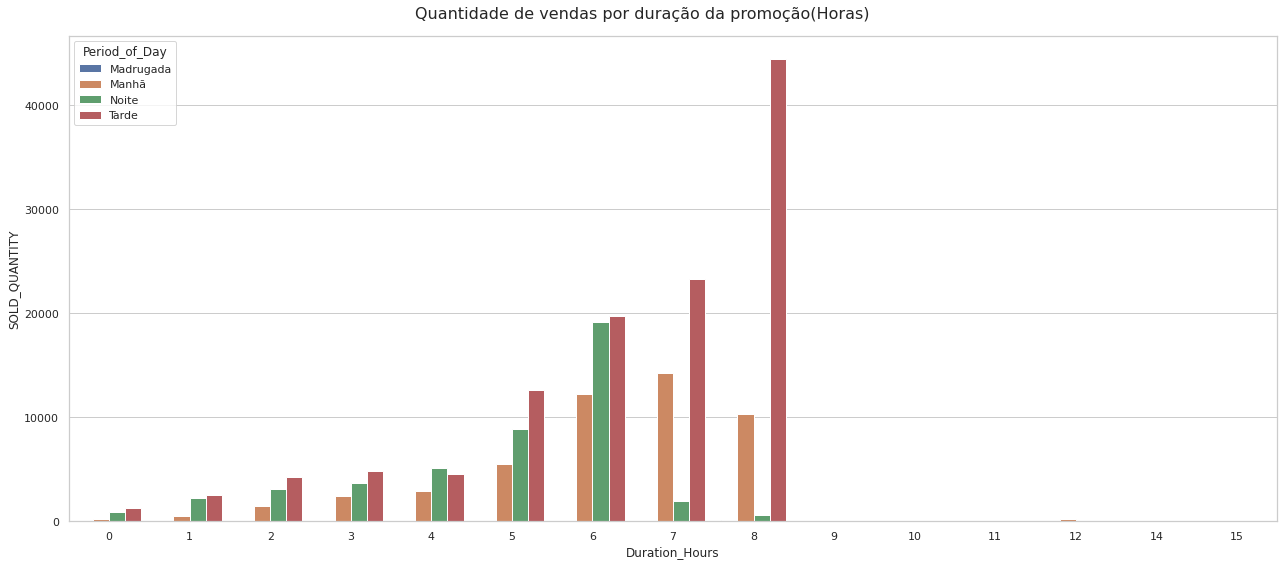

In [42]:
f = plt.figure()
f.suptitle('Quantidade de vendas por duração da promoção(Horas)', fontsize=16)
dataagg = data.groupby(['Period_of_Day','Duration_Hours'], as_index=False)['SOLD_QUANTITY'].sum()
ax = sns.barplot(x="Duration_Hours", y="SOLD_QUANTITY",hue='Period_of_Day', data=dataagg,ci=None)
plt.tight_layout()
plt.show()

Podemos perceber que um maior tempo de promoção leva a mais vendas totais, mas se focarmos na métrica de % de estoque vendido(Esgotamento de estoque) percebemos que promoções mais curtas tem uma performance melhor em média.

Por mais que os dados mostrem valores totais maiores quanto mais longas as promoções, seria interessante também saber a performance dessas promoções ao longo do tempo, por exemplo, percentualmente quanto foi vendido na primeira hora de todas as promoções?

# - O estoque limitado também influencia?

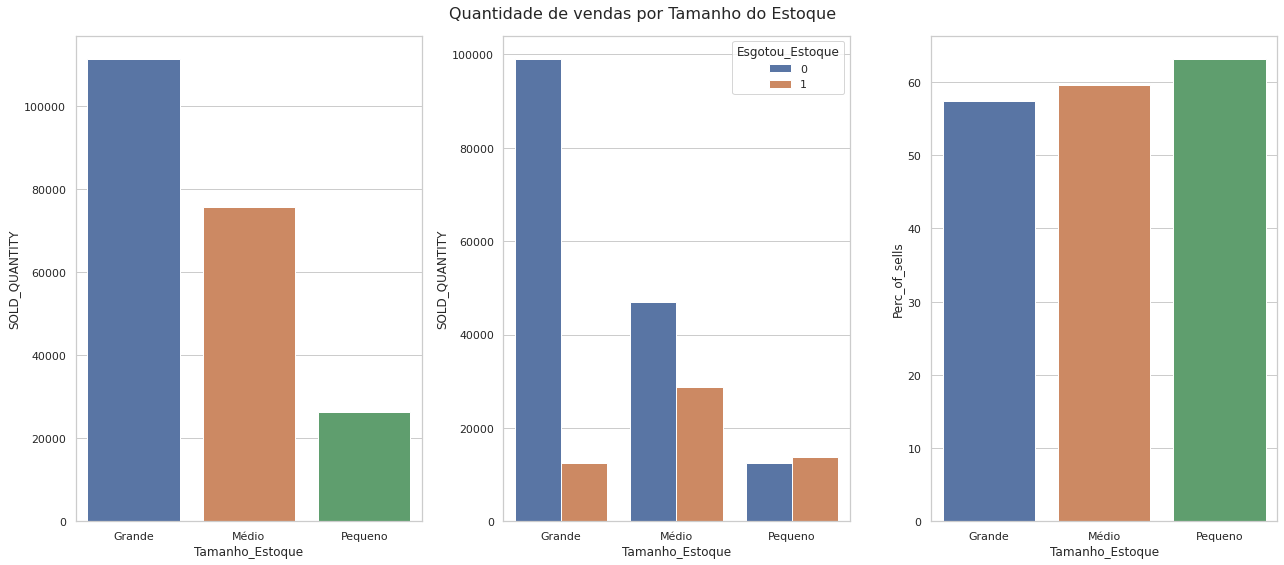

In [43]:
f = plt.figure()

f.suptitle('Quantidade de vendas por Tamanho do Estoque', fontsize=16)

dataagg = data.groupby(['Tamanho_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(131)
ax1 = sns.barplot(x="Tamanho_Estoque", y="SOLD_QUANTITY", data=dataagg,ci=None)
plt.tight_layout()

dataagg = data.groupby(['Tamanho_Estoque','Esgotou_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(132)
ax1 = sns.barplot(x="Tamanho_Estoque", y="SOLD_QUANTITY",hue='Esgotou_Estoque', data=dataagg,ci=None)
plt.tight_layout()

dataagg = data.groupby(['Tamanho_Estoque','Esgotou_Estoque'], as_index=False)['Perc_of_sells'].mean()
ax2 = f.add_subplot(133)
ax2 = sns.barplot(x="Tamanho_Estoque", y="Perc_of_sells", data=dataagg,ci=None)
plt.tight_layout()
plt.show()

Percebemos estoques menores proporcionalmente tem uma performance % de vendas melhor que estoques grandes e médios

# - Separar as ofertas por período do dia que aconteceram (manhã/tarde/noite/madrugada) e entender se há influencia na quantidade de vendas?

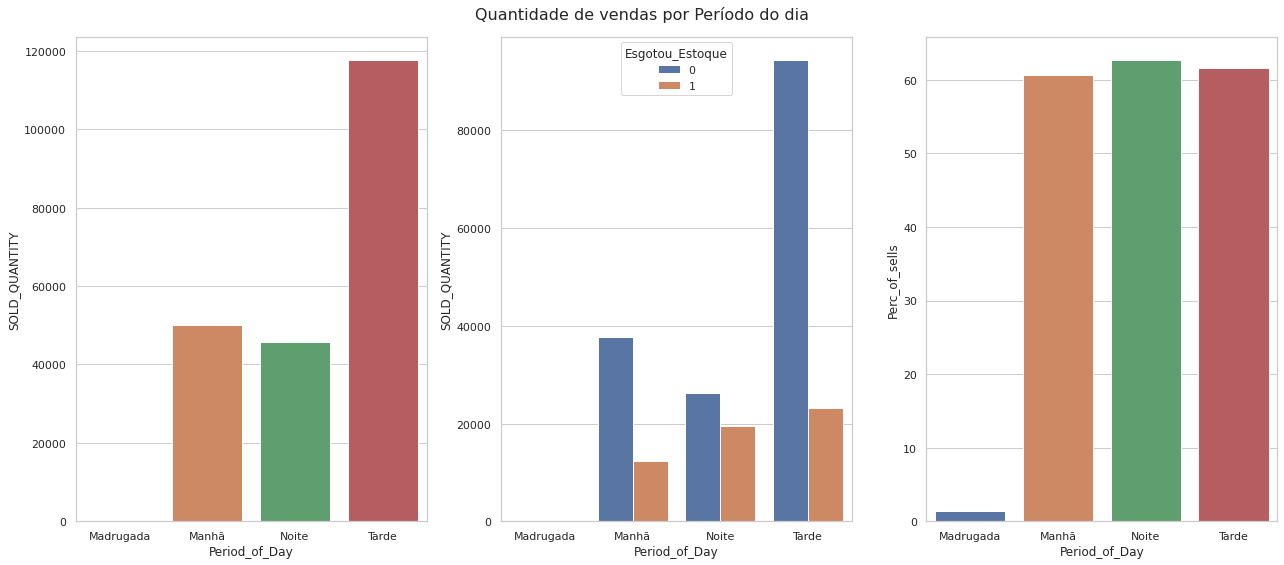

In [44]:
f = plt.figure()

f.suptitle('Quantidade de vendas por Período do dia', fontsize=16)

dataagg = data.groupby(['Period_of_Day'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(131)
ax1 = sns.barplot(x="Period_of_Day", y="SOLD_QUANTITY", data=dataagg,ci=None)
plt.tight_layout()


dataagg = data.groupby(['Period_of_Day','Esgotou_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
ax1 = f.add_subplot(132)
ax1 = sns.barplot(x="Period_of_Day", y="SOLD_QUANTITY",hue='Esgotou_Estoque', data=dataagg,ci=None)
plt.tight_layout()

dataagg = data.groupby(['Period_of_Day','Esgotou_Estoque'], as_index=False)['Perc_of_sells'].mean()
ax2 = f.add_subplot(133)
ax2 = sns.barplot(x="Period_of_Day", y="Perc_of_sells", data=dataagg,ci=None)
plt.tight_layout()
plt.show()

In [28]:
data.value_counts(['Period_of_Day'])

Period_of_Day
Tarde            20910
Manhã            14376
Noite            13386
Madrugada           74
dtype: int64

Em questão de performance, as vendas nos períodos diferentes não parecem ter muitas diferenças, a não ser de madrugada ( o que de certa forma é esperado tanto em quantidade, quanto no %)

Na venda total a tarde performou muito melhor que os outros períodos, mas temos que levar em consideração que a maioria das ofertas foram feitas neste período

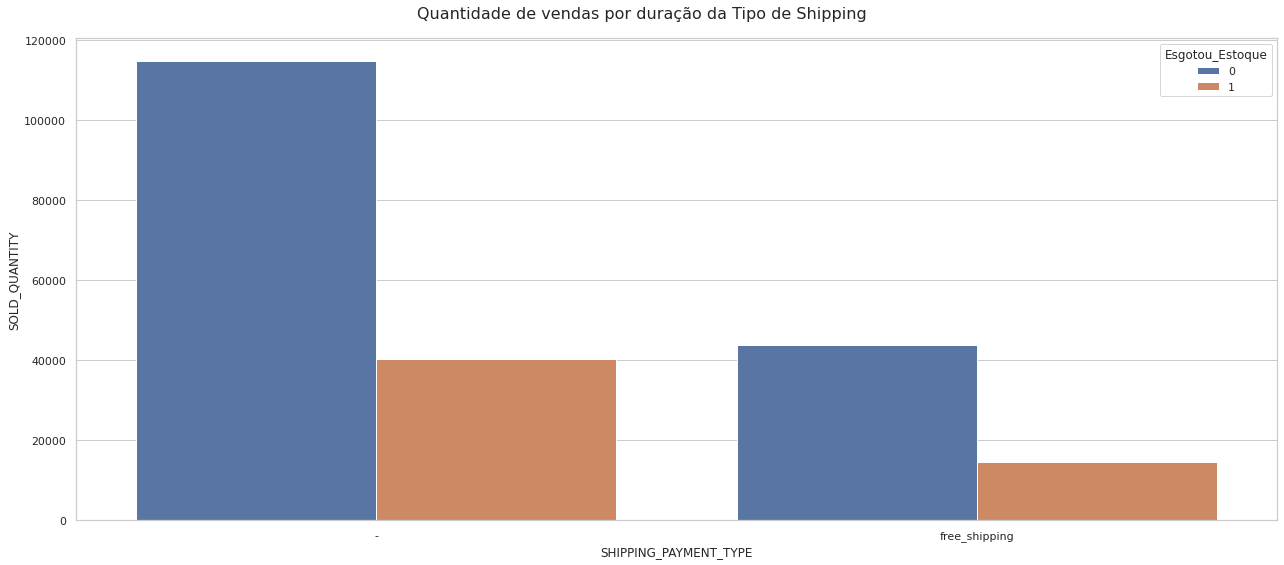

In [46]:
dataagg = data.groupby(['SHIPPING_PAYMENT_TYPE','Esgotou_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
fig, ax = plt.subplots()
fig.suptitle('Quantidade de vendas por duração da Tipo de Shipping', fontsize=16)
ax = sns.barplot(x="SHIPPING_PAYMENT_TYPE", y="SOLD_QUANTITY",hue='Esgotou_Estoque', data=dataagg,ci=None)
plt.tight_layout()
plt.show()

# - Os produtos com frete grátis performam melhores?
 
As ofertas em com frete grátis não parecem ter performado melhor que as com frete poagos

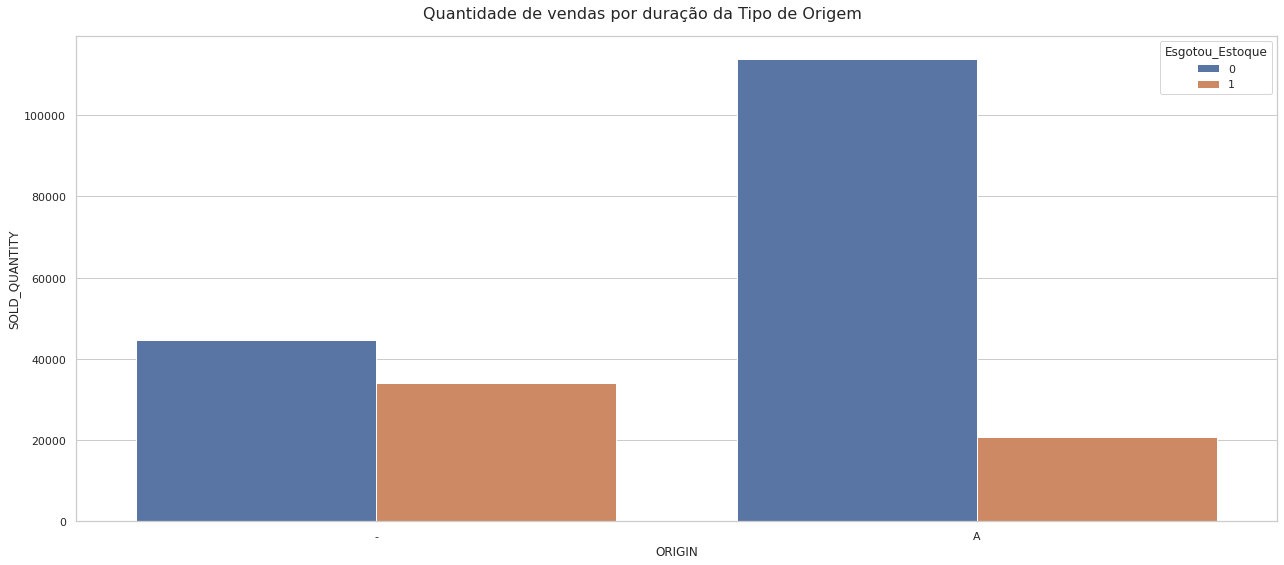

In [47]:
dataagg = data.groupby(['ORIGIN','Esgotou_Estoque'], as_index=False)['SOLD_QUANTITY'].sum()
fig, ax = plt.subplots()
fig.suptitle('Quantidade de vendas por duração da Tipo de Origem', fontsize=16)
ax = sns.barplot(x="ORIGIN", y="SOLD_QUANTITY",hue='Esgotou_Estoque', data=dataagg,ci=None)
plt.tight_layout()
plt.show()

Não consigo tirar nenhuma conclusão sem contexto do que significa a origem

# - Quais categorias performaram melhor (Vertical/Domain_ID/DOM_DOMAIN_AGG1)?

In [31]:
vendas_vertical = data.groupby(["VERTICAL","DOM_DOMAIN_AGG1"]).agg(Perc_of_sells = ('Perc_of_sells',np.mean), SOLD_QUANTITY = ('SOLD_QUANTITY', sum)).sort_values('SOLD_QUANTITY',ascending = False)
vendas_vertical.head(10)

Perc_of_sells  SOLD_QUANTITY
VERTICAL        DOM_DOMAIN_AGG1                                 
BEAUTY & HEALTH PHARMACEUTICS           32.474682          94967
                BEAUTY EQUIPMENT        24.882554          23324
HOME & INDUSTRY HOME&DECOR              21.304754          18132
CE              COMPUTERS               25.303325          11707
APP & SPORTS    SPORTS                  23.133807           7611
                APPAREL                 17.696664           7222
                APPAREL ACCESORIES      17.916494           7169
CE              MOBILE                  21.957249           6183
BEAUTY & HEALTH PERSONAL CARE           21.449236           6089
CE              ELECTRONICS             15.923855           5681

In [32]:
vendas_vertical.sort_values('Perc_of_sells',ascending = False).head(10)

,,Perc_of_sells,SOLD_QUANTITY
VERTICAL,DOM_DOMAIN_AGG1,,
CPG,PETS FOOD,37.052587,1493
BEAUTY & HEALTH,PHARMACEUTICS,32.474682,94967
HOME & INDUSTRY,SECURITY,28.479546,1151
ACC,VEHICULAR MULTIMEDIA,27.014652,292
OTHERS,ANTIQUES & HOBBIES,26.666667,10
CPG,BATTERIES,25.666667,181
ACC,AUTOPARTS,25.512873,3850
CE,COMPUTERS,25.303325,11707
BEAUTY & HEALTH,BEAUTY EQUIPMENT,24.882554,23324


In [33]:
data[data["VERTICAL"] == "BEAUTY & HEALTH"].groupby("DOMAIN_ID").agg(Perc_of_sells = ('Perc_of_sells',np.mean), SOLD_QUANTITY = ('SOLD_QUANTITY', sum)).sort_values('SOLD_QUANTITY',ascending = False).head()

,Perc_of_sells,SOLD_QUANTITY
DOMAIN_ID,,
MLM-SURGICAL_AND_INDUSTRIAL_MASKS,39.928718,88819
MLM-DISPOSABLE_GLOVES,40.208323,13058
MLM-OXIMETERS,25.921055,8105
MLM-THERMOMETERS,26.367626,3038
MLM-BLOOD_PRESSURE_MONITORS,44.555865,1303


BEAUTY & HEALTH performou muito bem tanto percentualmente quanto em quantidade total de vendas, principalmente na categoria Farmácia

Interessante perceber que os melhores produtos são artigos de saúde, visto que estamos falando de promoções em um período de pandemia, ajuda a explicar por que as máscaras, luvas, oxímetros e termometros performaram tão bem!

In [34]:
data.groupby(["DOMAIN_ID","VERTICAL"]).agg(Perc_of_sells = ('Perc_of_sells',np.mean), SOLD_QUANTITY = ('SOLD_QUANTITY', sum)).sort_values('SOLD_QUANTITY',ascending = False).head(10)

,,Perc_of_sells,SOLD_QUANTITY
DOMAIN_ID,VERTICAL,,
MLM-SURGICAL_AND_INDUSTRIAL_MASKS,BEAUTY & HEALTH,39.928718,88819
MLM-DISPOSABLE_GLOVES,BEAUTY & HEALTH,40.208323,13058
MLM-OXIMETERS,BEAUTY & HEALTH,25.921055,8105
MLM-HEADPHONES,CE,37.029627,4587
MLM-THERMOMETERS,BEAUTY & HEALTH,26.367626,3038
MLM-CELLPHONES,CE,18.791129,2245
MLM-LED_STRIPS,HOME & INDUSTRY,31.813489,1978
MLM-CHRISTMAS_LIGHTS,HOME & INDUSTRY,44.825708,1709
MLM-THERMOSES,APP & SPORTS,29.960085,1623


Fora a categoria de BEAUTY & HEALTH, percebemos fones de ouvido, celulares da CE e alguns ítens para casa

## Vamos fazer um Heatmap para avaliar a matriz de correlação:

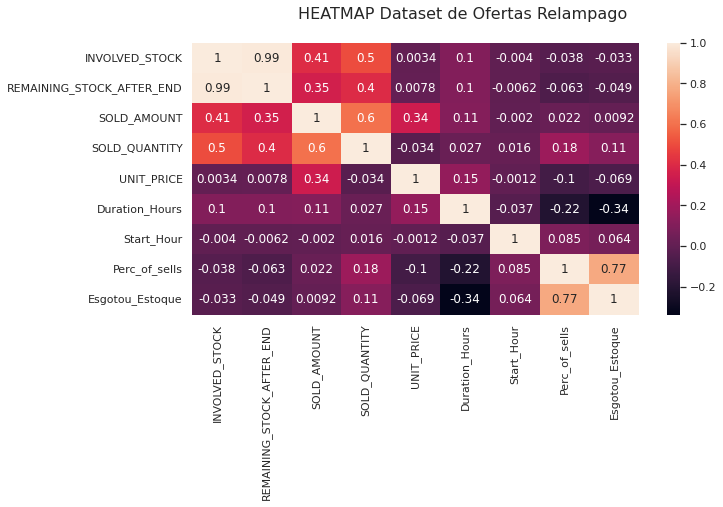

In [50]:
fig,ax =plt.subplots(figsize=(10,5))
fig.suptitle('HEATMAP Dataset de Ofertas Relampago', fontsize=16)
ax = sns.heatmap(data[['INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END',
       'SOLD_AMOUNT', 'SOLD_QUANTITY', 'UNIT_PRICE', 'Duration_Hours',
        'Start_Hour', 'Period_of_Day', 'Tamanho_Estoque', 'Perc_of_sells',
       'Esgotou_Estoque']].corr(), annot=True)

Fora as correlações obvias e de campos derivados, não percebemos nenhuma correlação tão forte